<a href="https://colab.research.google.com/github/Akramkhan01/Face-Emotion-Recognition-Deep-Learning-Project/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Name**

**Live Class Monitoring System(Face Emotion Recognition)**


# **Project Introduction**

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

# **Problem Statements**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.

The solution to this problem is by recognizing facial emotions.

# **What is Face Emotion Recognition**

Facial emotion recognition is the process of detecting human emotions from facial expressions. The human brain recognizes emotions automatically, and software has now been developed that can recognize emotions as well.

# **Dataset Information:**
I have built a deep learning model which detects the real time emotions of students through a webcam so that teachers can understand if students are able to grasp the topic according to students' expressions or emotions and then deploy the model. The model is trained on the FER-2013 dataset .This dataset consists of 35887 grayscale, 48x48 sized face images with seven emotions - angry, disgusted, fearful, happy, neutral, sad and surprised.




In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## CNN Models ##
import keras
import tensorflow as tf
from tensorflow.keras import optimizers
from keras.utils import np_utils
from keras.regularizers import l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D,concatenate
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import load_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
batch_size = 32
num_epochs = 50
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Face Emotion Recognition - Akram Khan

/content/gdrive/MyDrive/Face Emotion Recognition - Akram Khan


In [5]:
# Converting our data from tar file to csv file
import tarfile

fname = 'fer2013.tar.gz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [6]:
# Reading CSV file
df = pd.read_csv('/content/gdrive/MyDrive/Face Emotion Recognition - Akram Khan/fer2013/fer2013.csv')

In [7]:
# Printing shape of the data
print(df.shape)

(35887, 3)


In [8]:
# Return the first 5 rows.
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
# Return unique values emotion
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [10]:
# Dictionary mapping for individual emotions
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


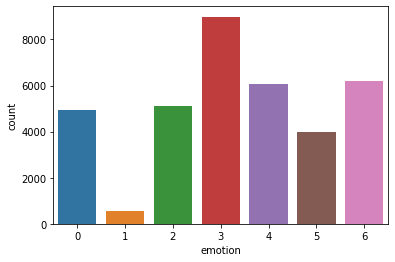

In [11]:
# Plotting distribution of emotions
sns.countplot(df.emotion)
plt.show()